# Vision Transformer (ViT) model for image classification


## Introduction
A lot of the recent state-of-the-art models are based on transformers. For example, [image classification on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet?dimension=Top%205%20Accuracy) benchmark is lead by architectures using transformers.

This example implements the [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) model for image classification, and demonstrates it on satellite images.

Vision Transformer is a type of artificial neural network architecture that is specifically designed for image recognition tasks. It is based on the Transformer architecture, which was originally developed for natural language processing tasks. The Vision Transformer uses self-attention mechanisms to process input data and make predictions, and it has been shown to be highly effective for a wide range of image recognition tasks. Some notable applications of Vision Transformers include object detection, image classification, and image generation



The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.

![fig](https://miro.medium.com/max/612/1*JmcLTzM1u71_1eq9s71reg.png)

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tarfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("You are on GPU !")
else:
  print('Change the runtime to GPU or continue with CPU, but this should slow down your trainings')
  device = torch.device("cpu")

You are on GPU !


In [3]:
#Loading the dataset
!wget -nv https://cerfacs.fr/opendata/cours/data/TRAIN.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/TEST.tar
!wget -nv https://cerfacs.fr/opendata/cours/data/y_train.npy

2024-01-09 11:13:26 URL:https://cerfacs.fr/opendata/cours/data/TRAIN.tar [44851200/44851200] -> "TRAIN.tar" [1]
2024-01-09 11:13:29 URL:https://cerfacs.fr/opendata/cours/data/TEST.tar [15687680/15687680] -> "TEST.tar" [1]
2024-01-09 11:13:31 URL:https://cerfacs.fr/opendata/cours/data/y_train.npy [1600128/1600128] -> "y_train.npy" [1]


In [4]:
# Using tarfile to create np arrays
def extract_files(dataset):
    tar = tarfile.open(dataset+'.tar', 'r')
    names = tar.getmembers()[:]
    images = [tar.extractfile(name) for name in names]
    return np.array([np.array(Image.open(image)) for image in images])

In [8]:
X_train = extract_files('TRAIN')
X_test = extract_files('TEST')
y_train = np.load('y_train.npy').reshape(-1, 1)
print("Train data : ",X_train.shape)
print("Train labels", y_train.shape)
print("Test data : ",X_test.shape)

Train data :  (20000, 64, 64, 3)
Train labels (20000, 1)
Test data :  (7000, 64, 64, 3)


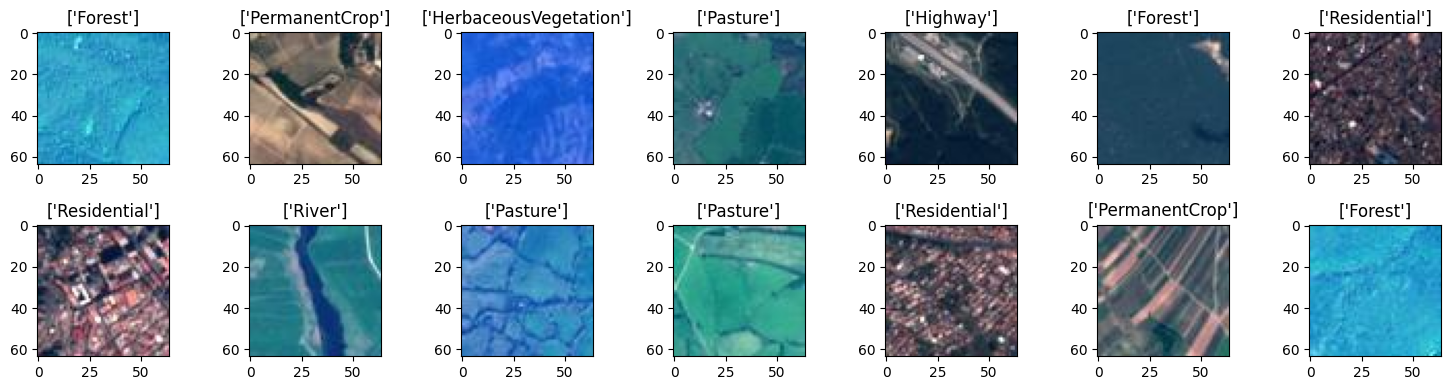

In [6]:
# Display data samples
fig, axes = plt.subplots(2, 7, figsize=(15, 4))
axes = axes.ravel()
for i in range(14):
    axes[i].imshow(X_train[i])
    axes[i].set_title(y_train[i])
plt.tight_layout()

In [9]:
y_train.shape, X_train.shape

((20000, 1), (20000, 64, 64, 3))

In [10]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train).toarray()

In [11]:
# Prepare data for training
X_train, X_test = X_train/255, X_test/255
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
print(mean)
print(std)

# Assuming X_train and y_train are PyTorch tensors
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and normalize images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

X_train_tensor = torch.stack([transform(img) for img in X_train]).float()
X_valid_tensor = torch.stack([transform(img) for img in X_valid]).float()
X_test_tensor = torch.stack([transform(img) for img in X_test]).float()
y_train_tensor = torch.from_numpy(y_train)
y_valid_tensor = torch.from_numpy(y_valid)

[0.29088279 0.41201959 0.48920503]
[0.2240432  0.17601508 0.21699366]


In [12]:
X_train_tensor.shape

torch.Size([16000, 3, 64, 64])

## Patches

The input to a ViT model is typically an image, which is divided into a grid of patches.

Here we implement a patche creator as a layer.

In [14]:
class Patches(nn.Module):
    def __init__(self, patch_size, num_patches=16):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.patch_dims = patch_size ** 2 * 3
        self.num_patches = num_patches

    def forward(self, images):
        batch_size, channels, height, width = images.size()
        # split image into patches
        patches = images.unfold(1, channels, channels).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(patches.size(0), -1, channels*self.patch_size*self.patch_size)

        return patches


Let's display patches for a sample image

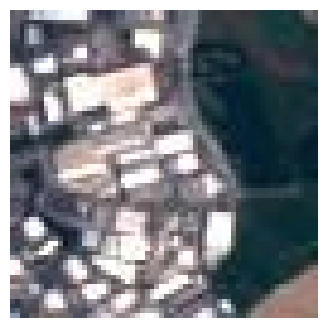

Image size: 64 X 64
Patch size: 16 X 16
Patches per image: 16
Elements per patch: 768


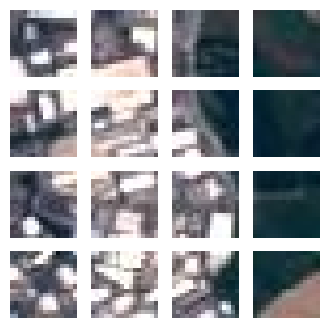

In [15]:
PATCH_SIZE = 16
IMAGE_SIZE = 64
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# Convert the NumPy image to a PyTorch tensor
image = X_train_tensor[np.random.choice(range(X_train.shape[0]))]
invTrans = transforms.Compose([ transforms.Normalize(mean = np.zeros_like(mean),
                                                     std = 1/std),
                                transforms.Normalize(mean = -mean,
                                                     std = np.ones_like(std)),
                               ])

image = invTrans(image)
# Create Patches instance
patches_layer = Patches(PATCH_SIZE, NUM_PATCHES)

# Extract patches
patches = patches_layer(image.unsqueeze(0))

image_array = torch.swapaxes(image, 2,0).numpy().astype(float)
# clip array's values to [0, 1]
image_array = np.clip(image_array, 0, 1)
# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(image_array)
plt.axis("off")
plt.show()

# Display the patches
print(f"Image size: {IMAGE_SIZE} X {IMAGE_SIZE}")
print(f"Patch size: {PATCH_SIZE} X {PATCH_SIZE}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = IMAGE_SIZE // PATCH_SIZE
plt.figure(figsize=(4, 4))
POSITIONS = []
for i in range(n):
    for j in range(n):
        ax = plt.subplot(n, n, j + n * i + 1)
        POSITIONS += [i + n*j]
        patch = patches[0,i + n*j,:]
        patch_img = patch.view(3, PATCH_SIZE, PATCH_SIZE)
        patch_img = np.clip(torch.swapaxes(patch_img, 2,0).numpy().astype(float), 0, 1)
        plt.imshow(patch_img)
        plt.axis("off")
plt.show()

## The Vision Transformer (ViT) model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, all the outputs of the final Transformer block are reshaped with `layers.Flatten()` then processed via a classifier head with softmax to produce the final class probabilities output

**What is Self-Attention Mechanism ?**

Self-attention is a mechanism that allows to a model to process input data by focusing on different parts of the input at different times. It is often used in natural language processing tasks, but can be applied to other types of data, in our case, images.

![](https://www.researchgate.net/publication/342301870/figure/fig1/AS:903976534962177@1592536209820/An-example-of-the-self-attention-mechanism-following-long-distance-dependency-in-the.png)

Imagine that you are trying to understand a sentence by reading it one word at a time. With self-attention, the model can "pay attention" to different words in the sentence at different times, and use this information to better understand the meaning of the sentence. For example, for processing the word "it" the model might "pay attention" to "The" and "monkey" more than the other parts of the sentence.


---
**Exercise 1**

Implement the transformer block of the ViT architecture (the gray block in the figure below).
![fig](https://miro.medium.com/max/612/1*JmcLTzM1u71_1eq9s71reg.png)
---


In [37]:
NUM_HEADS = 8
PROJECTION_DIM = 64
TRANSFORMER_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
NUM_CLASSES = 10
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MLP_HEAD_UNITS = [2048, 1024]  # Size of the dense layers of the final classifier

class TransformerBlock(nn.Module):
    def __init__(self):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.attention = nn.MultiheadAttention(embed_dim=PROJECTION_DIM, num_heads=NUM_HEADS)
        self.norm2 = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.mlp = MLP(PROJECTION_DIM, TRANSFORMER_UNITS)

    def forward(self, x):
        ### BEGIN SOLUTION
        # Layer normalization 1.
        x1 = self.norm1(x)
        # Multi-head attention.
        attention_output, _ = self.attention(x1, x1, x1)
        # Skip connection 1.
        x2 = x + attention_output
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        out = x2 + x3
        ### END SOLUTION
        return out

class MLP(nn.Module):
    def __init__(self, input_size, hidden_units, dropout_rate=0.0):
        super(MLP, self).__init__()
        self.fc_layers = nn.ModuleList()
        in_features = input_size

        for units in hidden_units:
            self.fc_layers.append(nn.Linear(in_features, units))
            in_features = units
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0.0 else None

    def forward(self, x):
        for layer in self.fc_layers:
            x = layer(x)
            x = F.gelu(x)
            if self.dropout:
                x = self.dropout(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, transformer_layers):
        super(VisionTransformer, self).__init__()
        self.patches_layer = Patches(PATCH_SIZE, NUM_PATCHES)

        self.projection = nn.Linear(3*PATCH_SIZE**2, PROJECTION_DIM)
        self.positions = torch.arange(NUM_PATCHES).unsqueeze(0).to(device)
        self.position_embeddings = nn.Embedding(NUM_PATCHES, PROJECTION_DIM)

        self.transformer_blocks = nn.ModuleList([TransformerBlock() for _ in range(transformer_layers)])
        self.layernorm = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.mlp_head = MLP(NUM_PATCHES*PROJECTION_DIM, MLP_HEAD_UNITS, dropout_rate=0.0)

        self.classifier = nn.Linear(MLP_HEAD_UNITS[-1], NUM_CLASSES)

    def forward(self, x):
        ### BEGIN SOLUTION
        patches = self.patches_layer(x)
        # Linearly transform a patch by projecting it into a vector of size `PROJECTION_DIM`.
        position_embeddings = self.position_embeddings(self.positions)
        projection = self.projection(patches)
        # Add a learnable position embedding to the projected vector.
        encoded_patches = position_embeddings + projection
        for transformer_block in self.transformer_blocks:
            encoded_patches = transformer_block(encoded_patches)

        representation = self.layernorm(encoded_patches)
        representation = representation.view(x.size(0), -1)
        features = self.mlp_head(representation)
        ### END SOLUTION
        logits = self.classifier(features)
        return logits

In [36]:
class VisionTransformer(nn.Module):
    def __init__(self, transformer_layers):
        super(VisionTransformer, self).__init__()
        self.patches_layer = Patches(PATCH_SIZE, NUM_PATCHES)

        self.projection = nn.Linear(3*PATCH_SIZE**2, PROJECTION_DIM)
        #self.positions = torch.Tensor(POSITIONS).unsqueeze(0).long().to(device)
        self.positions = torch.arange(NUM_PATCHES).unsqueeze(0).to(device)
        self.position_embeddings = nn.Embedding(NUM_PATCHES, PROJECTION_DIM)

        self.transformer_blocks = nn.ModuleList([TransformerBlock() for _ in range(transformer_layers)])
        self.layernorm = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.mlp_head = MLP(NUM_PATCHES*PROJECTION_DIM, MLP_HEAD_UNITS, dropout_rate=0.0)

        self.classifier = nn.Linear(MLP_HEAD_UNITS[-1], NUM_CLASSES)

    def forward(self, x):
        ### BEGIN SOLUTION
        patches = self.patches_layer(x)
        # Linearly transform a patch by projecting it into a vector of size `PROJECTION_DIM`.
        position_embeddings = self.position_embeddings(self.positions)
        projection = self.projection(patches)
        # Add a learnable position embedding to the projected vector.
        encoded_patches = position_embeddings + projection
        for transformer_block in self.transformer_blocks:
            encoded_patches = transformer_block(encoded_patches)

        representation = self.layernorm(encoded_patches)
        representation = representation.view(x.size(0), -1)
        features = self.mlp_head(representation)
        ### END SOLUTION
        logits = self.classifier(features)
        return logits


In [38]:
vit_model = VisionTransformer(transformer_layers=1)
print(vit_model)

VisionTransformer(
  (patches_layer): Patches()
  (projection): Linear(in_features=768, out_features=64, bias=True)
  (position_embeddings): Embedding(16, 64)
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc_layers): ModuleList(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): Linear(in_features=128, out_features=64, bias=True)
        )
      )
    )
  )
  (layernorm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
  (mlp_head): MLP(
    (fc_layers): ModuleList(
      (0): Linear(in_features=1024, out_features=2048, bias=True)
      (1): Linear(in_features=2048, out_features=1024, bias=True)
    )
  )
  (classifier): Linear(in_fe

## A CNN reference

Here we implement a CNN as a reference for comparison.

In [39]:
# Define the simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # ... (add more layers as needed)
        # self.fc = nn.Linear(..., 10)  # Output has 10 classes
        # YOUR CODE HERE
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjust input size based on your image dimensions
        self.fc = nn.Linear(512, 10)  # Output has 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        # ... (add forward pass for other layers)
        # YOUR CODE HERE
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])  # Adjust size based on your image dimensions
        x = F.relu(self.fc1(x))
        x = self.fc(x)
        return x

## Compile, train, and evaluate the model

---

**Exercise 2**

Train the CNN model over `NUM_EPOCHS` epochs using `Adam` optimizer with the given learning rate `LR`.

---

In [40]:
class CustomDataset(Dataset):
    def __init__(self, data_tensor, labels_tensor, transform=None):
        self.data_tensor = data_tensor
        self.labels_tensor = labels_tensor
        self.transform = transform

    def __len__(self):
        return len(self.data_tensor)

    def __getitem__(self, idx):
        img = self.data_tensor[idx]
        label = self.labels_tensor[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

In [41]:
LR = 3e-4
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32

transfos = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomGrayscale(p=0.1),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.2),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(X_train_tensor, y_train_tensor.argmax(dim=1))#, transform=transfos)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = CustomDataset(X_valid_tensor, y_valid_tensor.argmax(dim=1))
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
from tqdm import tqdm, notebook

def train(model, num_epochs, train_loader, valid_loader,lr=LR, weight_decay=0):
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize an empty dictionary to store accuracy
    history_dict = {'train_acc': [], 'valid_acc': [], 'train_loss': [], 'valid_loss': []}
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        with notebook.tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as train_bar:
            for inputs, labels in train_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                _, predicted_train = outputs.max(1)
                total_train += labels.size(0)
                correct_train += predicted_train.eq(labels).sum().item()

                # Update tqdm description with training loss
                train_bar.set_postfix({'Training Loss': train_loss / (train_bar.n + 1)})

        # Validation
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            with tqdm(valid_loader, desc='Validation', unit='batch') as valid_bar:
                for inputs, labels in valid_bar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()

                    _, predicted_valid = outputs.max(1)
                    total_valid += labels.size(0)
                    correct_valid += predicted_valid.eq(labels).sum().item()

                    # Update tqdm description with validation loss
                    valid_bar.set_postfix({'Validation Loss': valid_loss / (valid_bar.n + 1)})

        # Compute accuracy and store in dictionary
        accuracy_train = correct_train / total_train
        accuracy_valid = correct_valid / total_valid
        history_dict['train_acc'].append(accuracy_train)
        history_dict['valid_acc'].append(accuracy_valid)
        history_dict['train_loss'].append(train_loss / len(train_loader))
        history_dict['valid_loss'].append(valid_loss / len(valid_loader))

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {train_loss / len(train_loader):.3f}, '
              f'Validation Loss: {valid_loss / len(valid_loader):.3f}, '
              f'Training Accuracy: {100 * accuracy_train:.2f}%, '
              f'Validation Accuracy: {100 * accuracy_valid:.2f}%')

    return model, history_dict

In [43]:
NUM_FILTERS = 32

# Instantiate the model
cnn_model = SimpleCNN().to(device)

# Print the model architecture
print(cnn_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)


In [26]:
NUM_EPOCHS = 20
cnn_model, acc_dict_cnn = train(cnn_model, NUM_EPOCHS, train_loader, valid_loader)

Epoch 1/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 206.90batch/s, Validation Loss=0.955]

Epoch 1/20, Training Loss: 1.193, Validation Loss: 0.832, Training Accuracy: 55.09%, Validation Accuracy: 70.10%


Epoch 2/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 185.06batch/s, Validation Loss=0.769]


Epoch 2/20, Training Loss: 0.785, Validation Loss: 0.732, Training Accuracy: 71.55%, Validation Accuracy: 73.85%


Epoch 3/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 205.10batch/s, Validation Loss=0.83]


Epoch 3/20, Training Loss: 0.670, Validation Loss: 0.731, Training Accuracy: 75.96%, Validation Accuracy: 73.62%


Epoch 4/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 208.82batch/s, Validation Loss=0.741]


Epoch 4/20, Training Loss: 0.585, Validation Loss: 0.640, Training Accuracy: 79.15%, Validation Accuracy: 76.30%


Epoch 5/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 186.49batch/s, Validation Loss=0.599]


Epoch 5/20, Training Loss: 0.518, Validation Loss: 0.584, Training Accuracy: 81.68%, Validation Accuracy: 79.33%


Epoch 6/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 209.75batch/s, Validation Loss=0.653]

Epoch 6/20, Training Loss: 0.441, Validation Loss: 0.580, Training Accuracy: 84.38%, Validation Accuracy: 80.00%


Epoch 7/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 208.82batch/s, Validation Loss=0.574]

Epoch 7/20, Training Loss: 0.385, Validation Loss: 0.496, Training Accuracy: 86.22%, Validation Accuracy: 82.53%


Epoch 8/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 192.61batch/s, Validation Loss=0.51]


Epoch 8/20, Training Loss: 0.333, Validation Loss: 0.493, Training Accuracy: 88.10%, Validation Accuracy: 83.43%


Epoch 9/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 208.59batch/s, Validation Loss=0.527]


Epoch 9/20, Training Loss: 0.281, Validation Loss: 0.464, Training Accuracy: 89.91%, Validation Accuracy: 83.93%


Epoch 10/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 210.58batch/s, Validation Loss=0.593]

Epoch 10/20, Training Loss: 0.236, Validation Loss: 0.526, Training Accuracy: 91.73%, Validation Accuracy: 83.25%


Epoch 11/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 181.76batch/s, Validation Loss=0.517]


Epoch 11/20, Training Loss: 0.184, Validation Loss: 0.480, Training Accuracy: 93.54%, Validation Accuracy: 85.25%


Epoch 12/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 203.61batch/s, Validation Loss=0.621]


Epoch 12/20, Training Loss: 0.149, Validation Loss: 0.527, Training Accuracy: 94.71%, Validation Accuracy: 84.88%


Epoch 13/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 202.13batch/s, Validation Loss=0.591]

Epoch 13/20, Training Loss: 0.113, Validation Loss: 0.501, Training Accuracy: 96.18%, Validation Accuracy: 85.82%


Epoch 14/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 185.49batch/s, Validation Loss=0.55]


Epoch 14/20, Training Loss: 0.096, Validation Loss: 0.515, Training Accuracy: 96.56%, Validation Accuracy: 86.08%


Epoch 15/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 197.00batch/s, Validation Loss=0.83]


Epoch 15/20, Training Loss: 0.073, Validation Loss: 0.823, Training Accuracy: 97.47%, Validation Accuracy: 79.40%


Epoch 16/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 199.07batch/s, Validation Loss=0.828]

Epoch 16/20, Training Loss: 0.062, Validation Loss: 0.702, Training Accuracy: 98.02%, Validation Accuracy: 83.45%


Epoch 17/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 178.79batch/s, Validation Loss=0.705]


Epoch 17/20, Training Loss: 0.045, Validation Loss: 0.643, Training Accuracy: 98.59%, Validation Accuracy: 85.50%


Epoch 18/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 198.80batch/s, Validation Loss=0.73]

Epoch 18/20, Training Loss: 0.065, Validation Loss: 0.619, Training Accuracy: 97.87%, Validation Accuracy: 85.28%


Epoch 19/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 202.23batch/s, Validation Loss=0.832]


Epoch 19/20, Training Loss: 0.041, Validation Loss: 0.726, Training Accuracy: 98.76%, Validation Accuracy: 84.10%


Epoch 20/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 184.70batch/s, Validation Loss=0.685]

Epoch 20/20, Training Loss: 0.041, Validation Loss: 0.641, Training Accuracy: 98.76%, Validation Accuracy: 85.85%


In [44]:
def plot_accuracy(histories = {'CNN':None, 'ViT':None}, metric='acc'):
  n = len(histories.keys())
  plt.figure(figsize=(25,9))
  for j, key in enumerate(histories.keys()):
    ax = plt.subplot(1, n, j + 1)
    plt.plot(histories[key][f'train_{metric}'],label=f'Train {metric}')
    plt.plot(histories[key][f'valid_{metric}'],label=f'Validation {metric}')
    plt.legend()
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.title(key +" - " + "accuracy")
  plt.show()

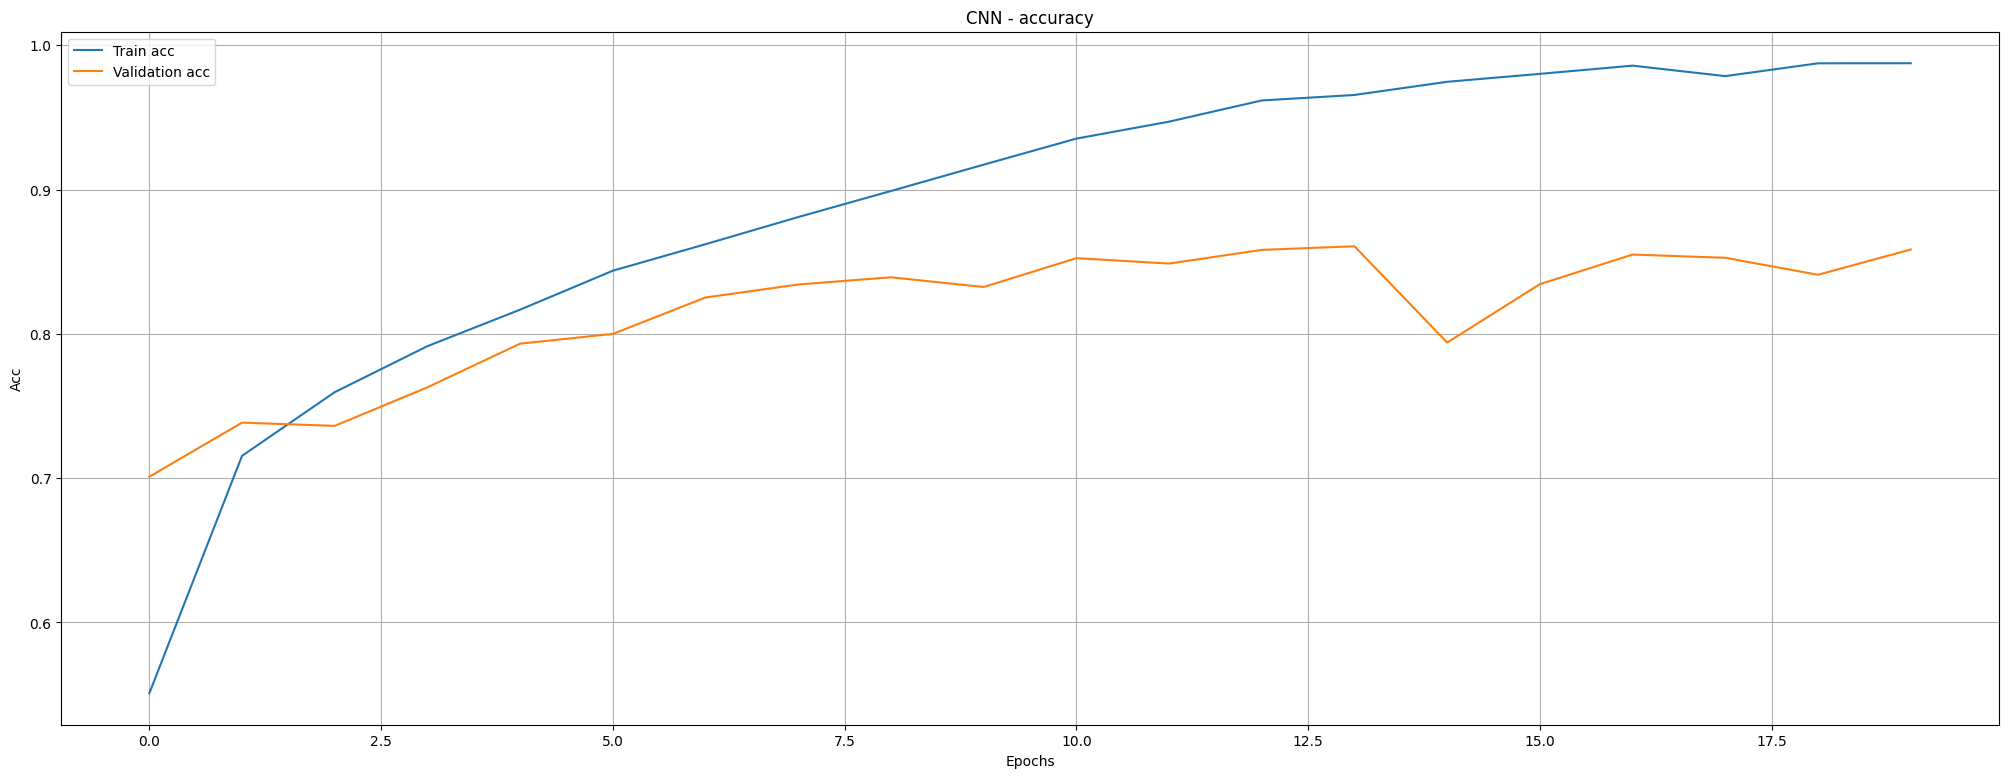

In [45]:
plot_accuracy(histories = {'CNN':acc_dict_cnn})

There is a clear overfitting, but the model reaches 80% accuracy.

---
**Exercise 3**

Now, train the ViT model using the same configuration.

---

In [46]:
TRANSFORMER_LAYERS = 4
vit_model = VisionTransformer(transformer_layers=TRANSFORMER_LAYERS).to(device)

In [47]:
vit_model, acc_dict_vit = train(vit_model, NUM_EPOCHS, train_loader, valid_loader)

Epoch 1/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 152.07batch/s, Validation Loss=1.17]

Epoch 1/20, Training Loss: 1.236, Validation Loss: 1.056, Training Accuracy: 55.23%, Validation Accuracy: 61.80%


Epoch 2/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 146.92batch/s, Validation Loss=0.931]

Epoch 2/20, Training Loss: 0.955, Validation Loss: 0.924, Training Accuracy: 65.91%, Validation Accuracy: 66.72%


Epoch 3/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 152.06batch/s, Validation Loss=1.03]

Epoch 3/20, Training Loss: 0.797, Validation Loss: 0.930, Training Accuracy: 71.52%, Validation Accuracy: 66.85%


Epoch 4/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 148.19batch/s, Validation Loss=1.08]

Epoch 4/20, Training Loss: 0.661, Validation Loss: 0.965, Training Accuracy: 76.17%, Validation Accuracy: 67.20%


Epoch 5/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:01<00:00, 120.62batch/s, Validation Loss=1.08]


Epoch 5/20, Training Loss: 0.515, Validation Loss: 1.065, Training Accuracy: 82.17%, Validation Accuracy: 66.38%


Epoch 6/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 159.53batch/s, Validation Loss=1.18]


Epoch 6/20, Training Loss: 0.373, Validation Loss: 1.117, Training Accuracy: 87.17%, Validation Accuracy: 67.40%


Epoch 7/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 157.46batch/s, Validation Loss=1.36]


Epoch 7/20, Training Loss: 0.258, Validation Loss: 1.287, Training Accuracy: 91.27%, Validation Accuracy: 66.45%


Epoch 8/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 154.05batch/s, Validation Loss=1.56]

Epoch 8/20, Training Loss: 0.188, Validation Loss: 1.437, Training Accuracy: 93.49%, Validation Accuracy: 66.70%


Epoch 9/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 155.87batch/s, Validation Loss=1.8]

Epoch 9/20, Training Loss: 0.157, Validation Loss: 1.644, Training Accuracy: 94.46%, Validation Accuracy: 65.28%


Epoch 10/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 125.00batch/s, Validation Loss=1.86]


Epoch 10/20, Training Loss: 0.156, Validation Loss: 1.725, Training Accuracy: 94.61%, Validation Accuracy: 65.05%


Epoch 11/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 148.79batch/s, Validation Loss=1.95]

Epoch 11/20, Training Loss: 0.106, Validation Loss: 1.750, Training Accuracy: 96.33%, Validation Accuracy: 66.38%


Epoch 12/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 139.38batch/s, Validation Loss=2.03]


Epoch 12/20, Training Loss: 0.091, Validation Loss: 1.914, Training Accuracy: 96.84%, Validation Accuracy: 64.95%


Epoch 13/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 150.69batch/s, Validation Loss=2.09]

Epoch 13/20, Training Loss: 0.084, Validation Loss: 1.919, Training Accuracy: 97.06%, Validation Accuracy: 65.80%


Epoch 14/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 151.34batch/s, Validation Loss=2.36]

Epoch 14/20, Training Loss: 0.084, Validation Loss: 2.115, Training Accuracy: 96.94%, Validation Accuracy: 65.05%


Epoch 15/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 126.04batch/s, Validation Loss=1.95]


Epoch 15/20, Training Loss: 0.084, Validation Loss: 1.949, Training Accuracy: 97.14%, Validation Accuracy: 65.62%


Epoch 16/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 148.66batch/s, Validation Loss=2.35]

Epoch 16/20, Training Loss: 0.053, Validation Loss: 2.087, Training Accuracy: 98.21%, Validation Accuracy: 66.75%


Epoch 17/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 149.56batch/s, Validation Loss=2.32]


Epoch 17/20, Training Loss: 0.075, Validation Loss: 2.097, Training Accuracy: 97.41%, Validation Accuracy: 64.80%


Epoch 18/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 150.11batch/s, Validation Loss=2.59]

Epoch 18/20, Training Loss: 0.063, Validation Loss: 2.320, Training Accuracy: 97.86%, Validation Accuracy: 64.60%


Epoch 19/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 154.97batch/s, Validation Loss=2.38]


Epoch 19/20, Training Loss: 0.066, Validation Loss: 2.208, Training Accuracy: 97.74%, Validation Accuracy: 66.47%


Epoch 20/20:   0%|          | 0/500 [00:00<?, ?batch/s]

Validation: 100%|██████████| 125/125 [00:00<00:00, 132.47batch/s, Validation Loss=2.42]

Epoch 20/20, Training Loss: 0.043, Validation Loss: 2.211, Training Accuracy: 98.59%, Validation Accuracy: 65.65%


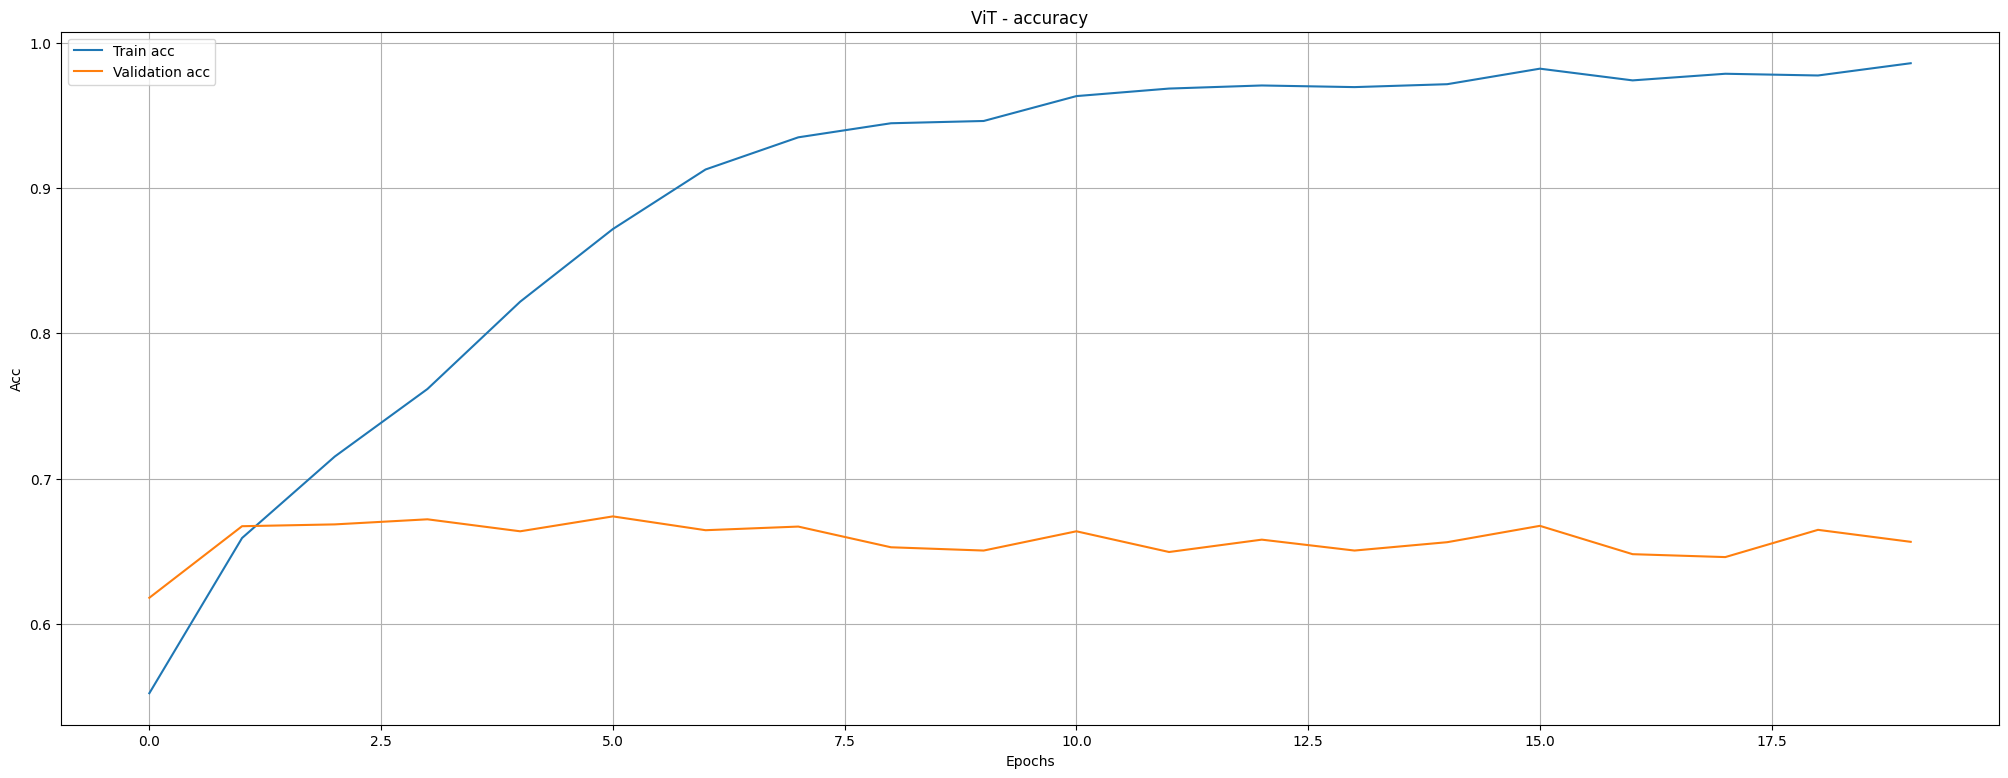

In [48]:
plot_accuracy(histories = {'ViT':acc_dict_vit})

Well, there is a significant overfitting happening here.

---
**Exercise 4**

- Add dropout rates to the `MultiHeadAttention` layer and to the MLP block of the transformer block (using a rate of 10% both)
- Add a `Dropout` layer just before the last MLP block (with a rate of 50%).
- Add dropout rate to the last MLP head block (using a rate of 50%).
- Use `Weight decay` in the optimzer.

---

**Weight decay**

Weight Decay, or $L_2$ Regularization, is a regularization technique  encouraging smaller weights. We minimize a loss function compromising both the primary loss function and a penalty on the weights:
$$\mathbf{L}(W) = \mathbf{L}_{original}(W) + \lambda ||W||2$$


Where $\lambda$ is a value determining the strength of the penalty.

In [1]:
class TransformerBlock(nn.Module):
    # YOUR CODE HERE
    def __init__(self):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.attention = nn.MultiheadAttention(embed_dim=PROJECTION_DIM, num_heads=NUM_HEADS, dropout=0.1)
        self.norm2 = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.mlp = MLP(PROJECTION_DIM, TRANSFORMER_UNITS, dropout_rate=0.5)

    def forward(self, x):
        # Layer normalization 1.
        x1 = self.norm1(x)
        # Multi-head attention.
        attention_output, _ = self.attention(x1, x1, x1)
        # Skip connection 1.
        x2 = x + attention_output
        # Layer normalization 2.
        x3 = self.norm2(x2)
        # MLP.
        x3 = self.mlp(x3)
        # Skip connection 2.
        out = x2 + x3
        return out
    ### END SOLUTION

class VisionTransformer(nn.Module):
    # YOUR CODE HERE
    def __init__(self, transformer_layers):
        super(VisionTransformer, self).__init__()
        self.patches_layer = Patches(PATCH_SIZE, NUM_PATCHES)

        self.projection = nn.Linear(3*PATCH_SIZE**2, PROJECTION_DIM)
        self.positions = torch.arange(NUM_PATCHES).unsqueeze(0).to(device)
        self.position_embeddings = nn.Embedding(NUM_PATCHES, PROJECTION_DIM)

        self.transformer_blocks = nn.ModuleList([TransformerBlock() for _ in range(transformer_layers)])
        self.layernorm = nn.LayerNorm(PROJECTION_DIM, eps=1e-6)
        self.mlp_head = MLP(NUM_PATCHES*PROJECTION_DIM, MLP_HEAD_UNITS, dropout_rate=0.5)

        self.classifier = nn.Linear(MLP_HEAD_UNITS[-1], NUM_CLASSES)
        self.dropout=nn.Dropout(0.5)

    def forward(self, x):
        patches = self.patches_layer(x)
        # Linearly transform a patch by projecting it into a vector of size `PROJECTION_DIM`.
        position_embeddings = self.position_embeddings(self.positions)
        projection = self.projection(patches)
        # Add a learnable position embedding to the projected vector.
        encoded_patches = position_embeddings + projection
        for transformer_block in self.transformer_blocks:
            encoded_patches = transformer_block(encoded_patches)

        representation = self.layernorm(encoded_patches)
        representation = representation.view(x.size(0), -1)
        representation = self.dropout(representation)
        features = self.mlp_head(representation)
        logits = self.classifier(features)
        return logits

NameError: name 'nn' is not defined

In [ ]:
TRANSFORMER_LAYERS = 8
vit_model_2 = VisionTransformer(transformer_layers=TRANSFORMER_LAYERS).to(device)
vit_model_2, acc_dict_vit_2 = train(vit_model_2, NUM_EPOCHS, train_loader, valid_loader, weight_decay=WEIGHT_DECAY)

In [ ]:
plot_accuracy(histories = {'ViT':acc_dict_vit})

We have increased accuracy by 10% and reduced the gap between the training score and the validation score. We're still a long way from CNN's 80% accuracy, but that gives you an idea about ViT's scalability potential.

Now you can use all the available data to train the ViT. You can also increase the complexity of the ViT by using more transformer layers.

Another possibility is to take advantage of the hype around transformers to find a pre-trained model for transfer learning.

## Attention rollout
To investigate the learned representations, [Abnar et al](https://arxiv.org/abs/2005.00928). introduce "Attention rollout" for quantifying how information flow through self-attention layers of Transformer blocks, this is computed by averaging attention weights of a ViT across all heads and multipliying the weight matrices of all layers.

We don't implement it here, but here is an example of the resulting attention map of a ViT.

![](https://github.com/relmonta/machine-learning/blob/main/source/TP8/attention_rollout.png?raw=1)

![](https://user-images.githubusercontent.com/68524289/117996628-454ead00-b37d-11eb-8717-8135f57b7fac.png)

Refer to the [Keras doc](https://keras.io/examples/vision/probing_vits/#method-ii-attention-rollout) for more details.